In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import lightgbm as lgb
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
# 特徴量と目的変数の設定
X = df.drop(['MEDV'], axis=1)
y = df['MEDV']
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

In [4]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)


X_trainの形状： (404, 13)  y_trainの形状： (404,)  X_testの形状： (102, 13)  y_testの形状： (102,)


In [5]:
# ハイパーパラメータの設定
lgb_train = lgb.Dataset(X_train, y_train)

params = {
  'objective': 'mse',
  'num_leaves': 5,
  'seed': 0,
  'verbose': -1
}

In [6]:
# モデルの学習
model = lgb.train(
  params,
  lgb_train,
  num_boost_round=50,
  valid_sets=[lgb_train],
  valid_names=['train'],
  callbacks=[lgb.log_evaluation(5)]
)

[5]	train's l2: 41.0826
[10]	train's l2: 23.2264
[15]	train's l2: 15.2148
[20]	train's l2: 11.4353
[25]	train's l2: 9.40517
[30]	train's l2: 8.26905
[35]	train's l2: 7.49852
[40]	train's l2: 6.83309
[45]	train's l2: 6.31007
[50]	train's l2: 5.88687


In [7]:
# 学習データの予測と評価
y_train_pred = model.predict(X_train)
print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('RMSE train: %.2f' % (mean_squared_error(y_train, y_train_pred) ** 0.5))

MSE train: 5.89
RMSE train: 2.43


In [8]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test)
print('MSE test: %.2f' % (mean_squared_error(y_test, y_test_pred)))
print('RMSE test: %.2f' % (mean_squared_error(y_test, y_test_pred) ** 0.5))


MSE test: 24.66
RMSE test: 4.97


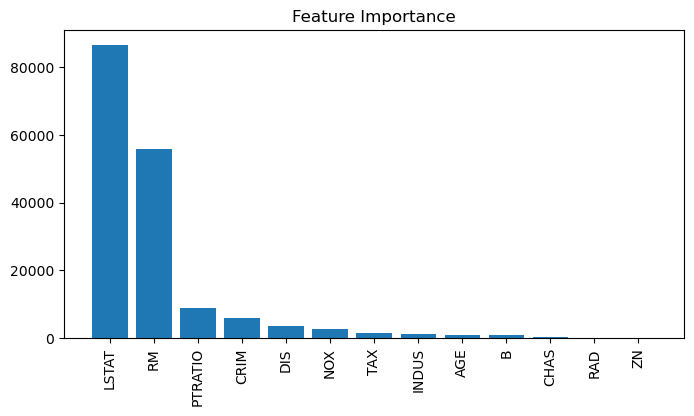

In [9]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量の重要度
indices = np.argsort(importances)[::-1] # 特徴量の重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title('Feature Importance') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示

<Axes: >

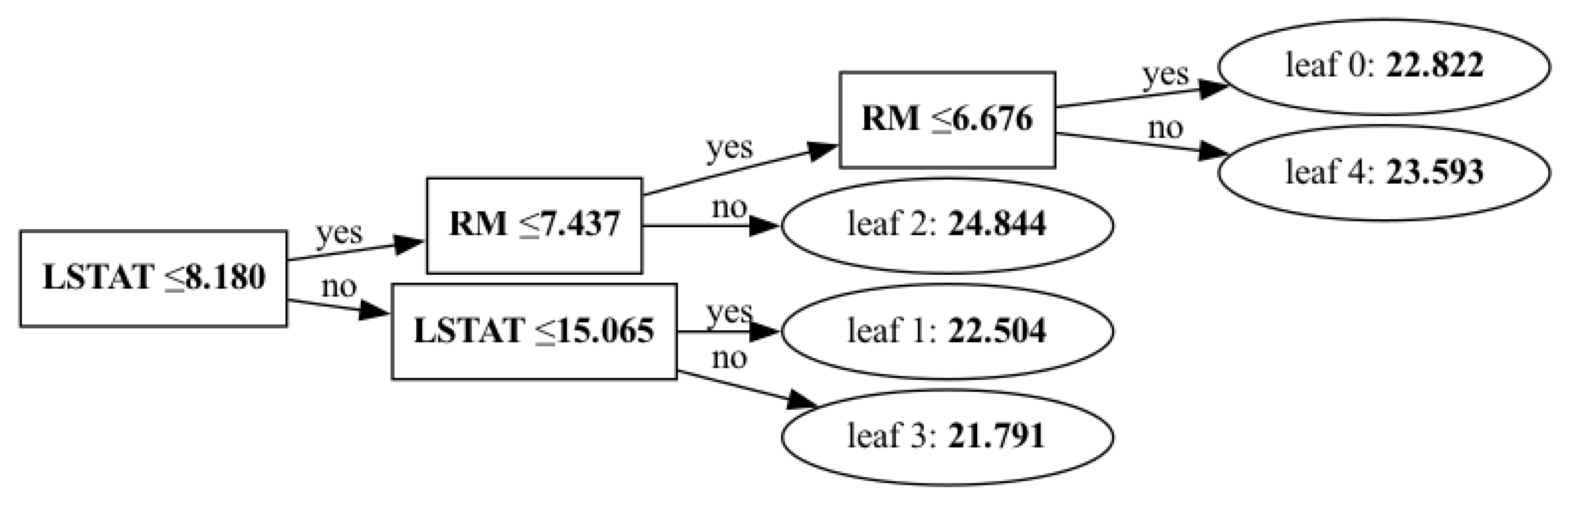

In [10]:
# 1本目の木の可視化
lgb.plot_tree(model, tree_index=0, figsize=(20, 20))


<Axes: >

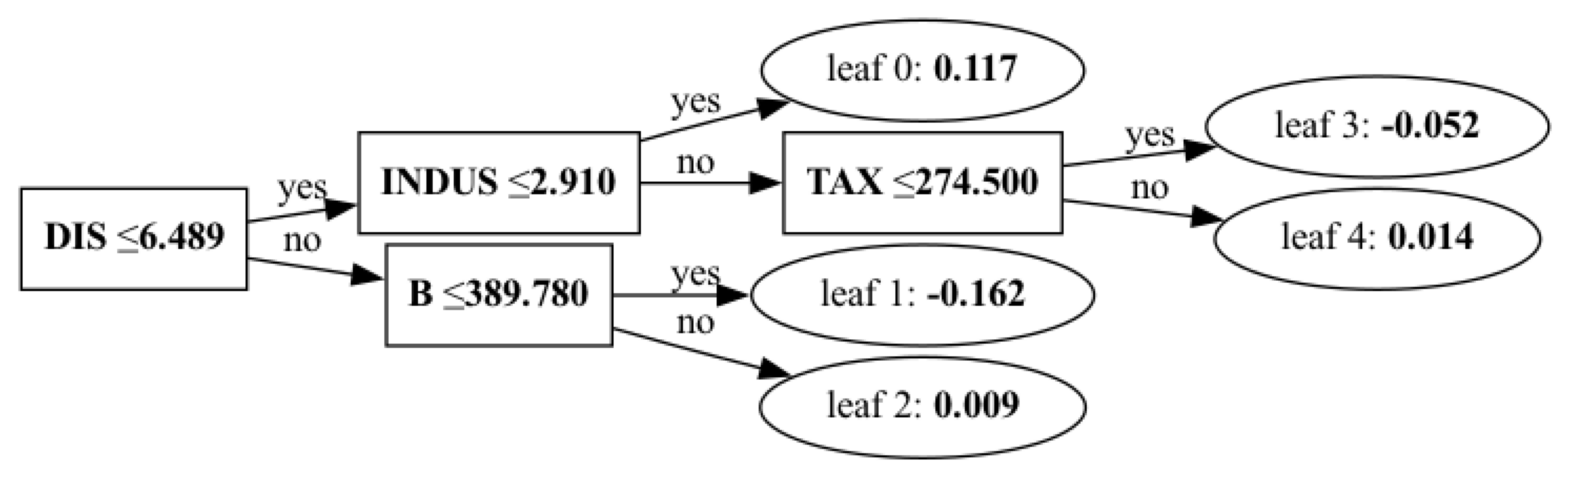

In [11]:
# 50本目の木の可視化
lgb.plot_tree(model, tree_index=-1, figsize=(20, 20))

In [12]:
import shap
shap.__version__

'0.44.1'

In [14]:
# explainerの作成
import shap
explainer = shap.TreeExplainer(
    model = model,
    feature_pertubation = 'tree_path_dependent')

In [15]:
# SHAP値の計算
shap_values = explainer(X_test)
# 全件レコードの期待値
explainer.expected_value

22.611881236511856

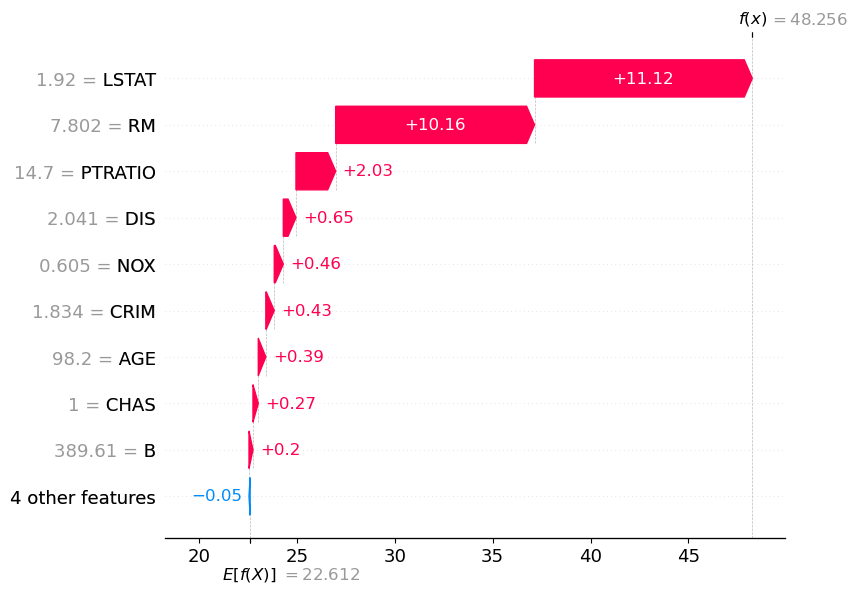

In [17]:
shap.plots.waterfall(shap_values[14])


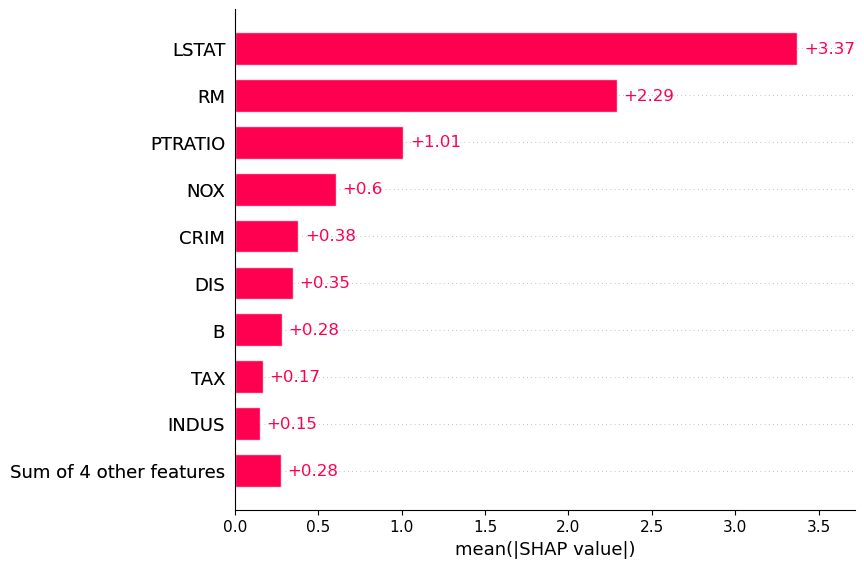

In [18]:
# 特徴量重要度の可視化
shap.plots.bar(shap_values=shap_values)
